# General info
__Author__ = Reask <br>
__copyright__ = "Copyright 2024, Reask"

The script processes the sample trackset (120 years) and finds events at targets locations (latitude/longitude) defined by user user-defined <br>
Following are the items produced by this script: <br>
1. landfalling events at user-defined locations and intensity threshold
2. Exceedance probability of cyclone intensity



### User input


In [58]:
# Input track file
trackfile = 'North_Atlantic_Trackset_Sample_120years.csv'

# LOCATION 1: Miami [Name, Latitude, Longitude]
loc1 = ['Miami', 25.75, -80]

# LOCATION 2: New Orleans [Name, Latitude, Longitude]
loc2 = ['New Orleans', 30, -90]

# Search radius in miles
srad = 200

# Intensity (windspeed in m/s) threshold at Location 1 
# for loc 1
Vmax1 = 43 # Category 2 intensity
# for loc 1
Vmax2 = 33 # Category 1 intensity

### Step1: Load Python packges 

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import glob as glob
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom

### Step 2: functions

In [60]:
# converting search radius from miles to kilometers
srad *= 1.60934

# create dataframe (table) of user locations
df_loc = pd.DataFrame([loc1, loc2]).rename(columns = {0: 'City', 1: 'lat', 2: 'lon'})

# function to calculate distance between track points and user-defined location
def calc_d(lat,lon, plat,plon):
    dist = 111* np.sqrt(((lat-plat)**2) + ((lon-plon)**2))
    return dist



# create search radius circle polygons
geoms = []
for lon, lat in zip(df_loc['lon'], df_loc['lat']):
        cp = gd.circle(lon=lon, lat=lat, radius=srad*1000)
        geoms.append(sgeom.Polygon(cp))

# function to plot tracks
def plot_tracks(df, loc=None, title=None):

        src_crs = ccrs.PlateCarree()

        fig, ax = plt.subplots(figsize=(12, 12),
                        subplot_kw=dict(projection=src_crs))

        extent = [-100, -67, 20, 45]

        ax.add_feature(cfeature.STATES, zorder=200, linewidth=0.5, edgecolor='k')
        ax.add_geometries(geoms, crs=src_crs, edgecolor='r', alpha=0.5,zorder=200)

        ax.set_extent(extent)
        ax.coastlines('10m', color="grey", linewidth=1, zorder=200, alpha=1)
        ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='grey', zorder=100)

        if loc is not None:  
               ax.scatter(loc[2], loc[1], color = 'r', s=200, zorder=300)
        else:
                ax.scatter(loc1[2], loc1[1], color = 'r', s=200, zorder=300)
                ax.scatter(loc2[2], loc2[1], color = 'r', s=200, zorder=300)
        

        for ii in df.SID.unique() :
                b = df.loc[df.SID==ii].reset_index(drop=True)
                ax.plot(b.LON,b.LAT,color='k',zorder=200)

        if title is not None:
                ax.set_title(title, fontsize=25)



### Step 3: Read track file and calculate distance

In [61]:
# read input track csv file
trackset = pd.read_csv(trackfile)

# convert track longitude format form 0/360 to -180/180 
trackset["LON"] = (trackset["LON"] + 180) % 360 - 180

# calculate distance between track points and user location 1
trackset["dist1"] = trackset.apply(lambda row: calc_d( row.LON, row.LAT, loc1[2], loc1[1]), axis=1 )

# calculate distance between track points and user location 1
trackset["dist2"] = trackset.apply(lambda row: calc_d( row.LON, row.LAT, loc2[2], loc2[1]), axis=1 )

### Step 4: Filter events

In [62]:
# filter events for location 1 under 1) search radius and 2) intensity threshold
sids_loc1 = trackset.loc[(trackset.dist1 < srad) & (trackset.Vm > Vmax1)]['SID'].unique()
track_loc1 = trackset.loc[trackset.SID.isin(sids_loc1)]
print('No of events passing through ' + loc1[0] + ' is ' + str(sids_loc1.shape[0]))

# filter events for location 2 under 1) search radius and 2) intensity threshold
sids_loc2 = trackset.loc[(trackset.dist2 < srad) & (trackset.Vm > Vmax2)]['SID'].unique()
track_loc2 = trackset.loc[trackset.SID.isin(sids_loc2)]
print('No of events passing through ' + loc2[0] + ' is ' + str(sids_loc2.shape[0]))

# store storm IDs for events that passes through both locations
sids_conditional = track_loc1.loc[(track_loc1.dist2 < srad) & (track_loc1.Vm > Vmax2)]['SID'].unique()
track_conditional = track_loc1.loc[track_loc1.SID.isin(sids_conditional)]

print('No of events passing through ' + loc1[0] + ' and ' + loc2[0] + ' is ' + str(sids_conditional.shape[0]))


No of events passing through Miami is 64
No of events passing through New Orleans is 83
No of events passing through Miami and New Orleans is 9


### Step 5: Plot tracks

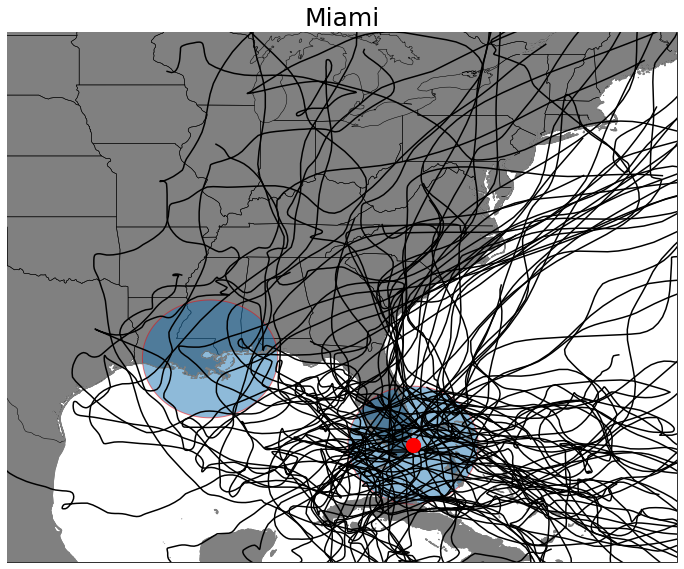

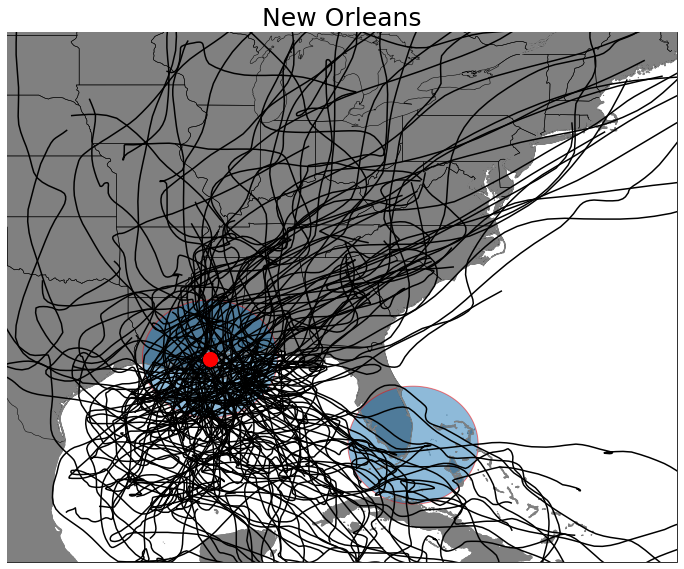

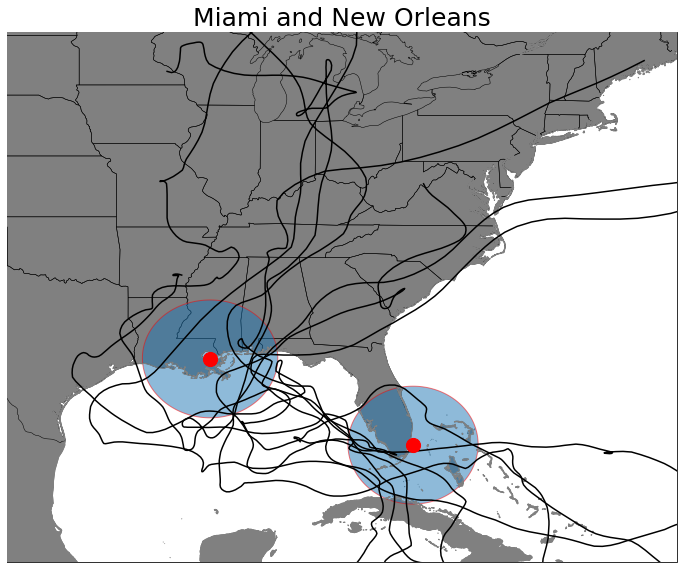

In [63]:
plot_tracks(track_loc1, loc1, 'Miami')
plot_tracks(track_loc2, loc2, 'New Orleans')
plot_tracks(track_conditional, None, 'Miami and New Orleans')

### Some basic STATS